<a href="https://colab.research.google.com/github/polortiz4/Smart-Cameras/blob/master/Smart_Cameras_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demosaicking Homework
## Pablo Ortiz
### 02/13/19

In [37]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage
import skimage.io as imio
import skimage.transform as trans
from skimage.viewer import ImageViewer
import glob
import re
from time import gmtime, strftime, sleep
import subprocess
import os
%matplotlib inline

mpl.rcParams['figure.figsize'] = (16.0, 8.0)

In [2]:
def grabImage(sid = 1, imres = 8, cameraIP = '10.236.176.38'):
    cmdA = 'ssh -i ~/.ssh/id_rsa_nopassword nvidia@' + cameraIP # Run a command in the DISP camera
    cmdB = 'scp -i ~/.ssh/id_rsa_nopassword nvidia@' + cameraIP # Copy a file from the DISP camera
    
    cmdD = ' "nvgstcapture-1.0 -m 1 --sensor-id ' + str(sid) + ' -A --capture-auto 1 --dump-bayer \
    --file-name dbGrab --image-res ' + str(imres) + '"'
    
    subprocess.run('bash -c ' + "'rm dbGrab*'", stdout = subprocess.PIPE, shell = True)
    subprocess.run('bash -c '+"'rm *.raw'", stdout = subprocess.PIPE, shell = True)
    
    subprocess.run('bash -c ' + "'" + cmdA +' "rm dbGrab*"' + "'", stdout = subprocess.PIPE, shell = True)
    subprocess.run('bash -c ' + "'" + cmdA + ' "rm *.raw"' + "'", stdout = subprocess.PIPE, shell = True)
    subprocess.run('bash -c ' + "'" + cmdA + cmdD + "'", stdout = subprocess.PIPE, shell = True)
    
    subprocess.run('bash -c ' + "'" + cmdB + ':dbGrab* .' + "'", stdout = subprocess.PIPE, shell = True)
    subprocess.run('bash -c ' + "'" + cmdB + ':*.raw .' + "'", stdout = subprocess.PIPE, shell = True)
    
    # Clean the camera
    subprocess.run('bash -c ' + "'" + cmdA +' "rm dbGrab*"' + "'", stdout = subprocess.PIPE, shell = True)
    subprocess.run('bash -c ' + "'" + cmdA + ' "rm *.raw"' + "'", stdout = subprocess.PIPE, shell = True)
    
    pop = subprocess.run("bash -c 'ls'", stdout = subprocess.PIPE, shell = True)
    rePop = pop.stdout
    rePop = rePop.decode('utf-8')
    fileName = re.search(r'dbGrab(.*).jpg', rePop)
    fileName = fileName.group()
    jIm = imio.imread(fileName)
    
    fileName = re.search(r'(.*).raw', rePop)
    fileName = fileName.group()
    rIm = np.fromfile(fileName, dtype = np.dtype('i2'))
    rows = 2190
    runL = 3864
    rIm = np.reshape(rIm[:rows * runL], (rows, runL))
    rIm = np.rot90(rIm, 2)
    return [jIm, rIm]


# Capture Raw Bayer images and display/compare their patter

In [12]:
jIm, rIm = grabImage(sid = 0, imres = 8)

## Extract the RGB Color Planes

First, we want to analyze the captured image to see where how the Bayer pattern is places. (is it GBGR, BGGR, RGGB, or RGBG?)

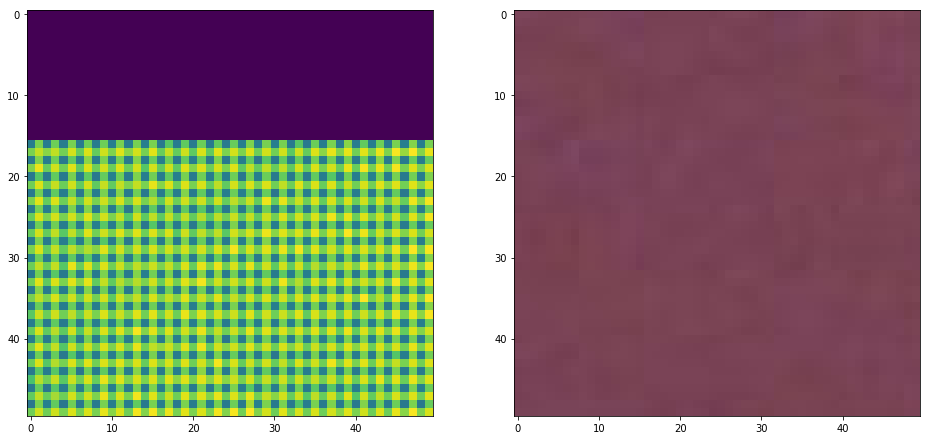

In [25]:
plt.subplot(1,2,1)
plt.imshow(rIm[:50, :50])
plt.subplot(1,2,2)
plt.imshow(jIm[:50, :50])
# plt.imshow(rIm[1600:1750,1300:1400])

From close analysis of these pixels in the raw data and compared to the jpeg image, we can observe that the pattern is BGGR. That is because the pixels in the fourth quadrant are brighter than the other ones suggesting they are the red ones. You can tell which are the blue pixels by observing the dim pixels are spaced out as opposed to patterned in diagonals. 

In [20]:
green1 = rIm[1::2, ::2] 
green2 = rIm[::2, 1::2] 
red = rIm[1::2, 1::2] 
blue = rIm[::2, ::2] 

To verify that the channels were extracted correctly, we zoom in to the color markers and observe if the channels correspond to their respective colors (each color channel should show it's respective marker color in highest brightness). 

Text(0.5, 1.0, 'Red')

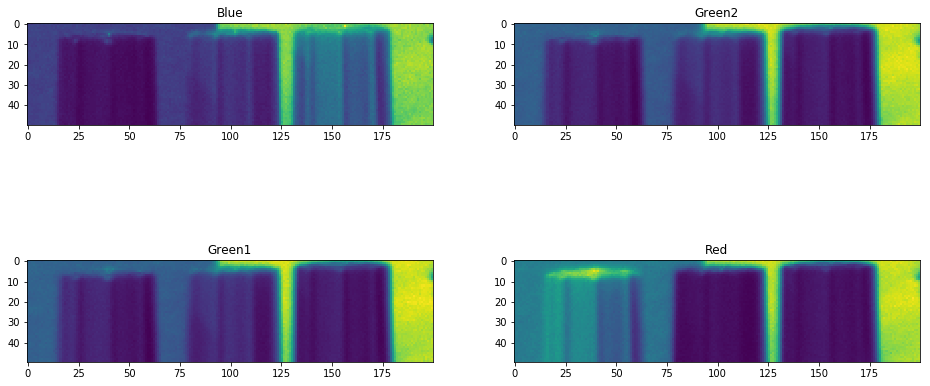

In [21]:
plt.subplot(2, 2, 1)
plt.imshow(blue[950:1000, 400:600])
plt.title('Blue')
plt.subplot(2, 2, 2)
plt.imshow(green2[950:1000, 400:600])
plt.title('Green2')
plt.subplot(2, 2, 3)
plt.title('Green1')
plt.imshow(green1[950:1000, 400:600])
plt.subplot(2, 2, 4)
plt.imshow(red[950:1000, 400:600])
plt.title('Red')


It can be seen in these how the color channels were infact extracted correctly: the blue marker only lights up in th blue channel, and the red marker only lights up in the red channel.

## Display the channels to compare them: 

Text(0.5, 1.0, 'Red')

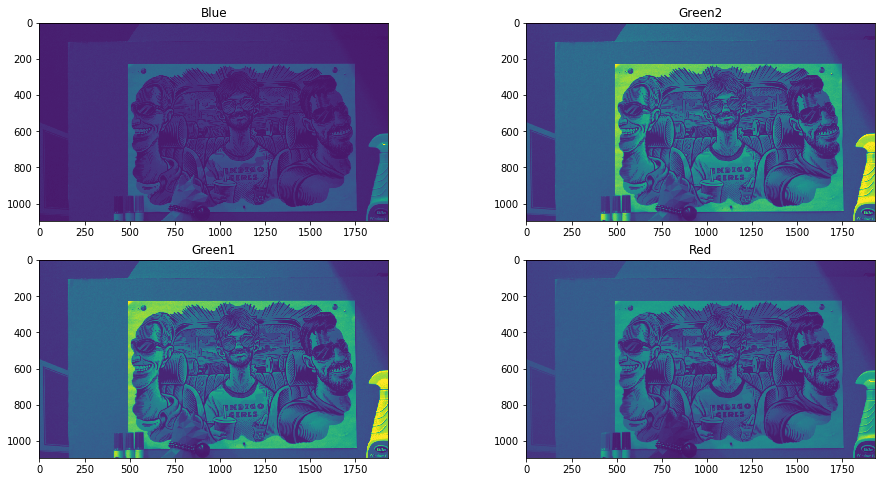

In [22]:
plt.subplot(2, 2, 1)
plt.imshow(blue)
plt.title('Blue')
plt.subplot(2, 2, 2)
plt.imshow(green2)
plt.title('Green2')
plt.subplot(2, 2, 3)
plt.title('Green1')
plt.imshow(green1)
plt.subplot(2, 2, 4)
plt.imshow(red)
plt.title('Red')

The first thing to observe from these images is that the blue component of the image is the dimmest, which goes to show that either the scene is mostly composed by larger wavelength colors, or the camera is least sensitive to blue. 
Another noticeable feature in this image is that the white color in the Gile fluid container appears more bright in the green channels, even though it is supposed look more or less even for all channels. This suggests that the camera is more sensitive to green pixels, which can be corrected for in color adjustment.

# Develop our own Demosaicking and Color Adjustment

In [30]:
def shifted_sigmoid(x):
    return 1/(1+np.exp(-x)) - 0.5

In [49]:
def adjustColor(inputImage, rc = 1, bc = 1, gc = 1, gain = 1):
    fI = inputImage.astype(np.float)
    fI[:, :, 0] = rc * fI[:, :, 0]
    fI[:, :, 1] = gc * fI[:, :, 1]
    fI[:, :, 2] = bc * fI[:, :, 2]
    fI=255*np.tanh(gain*fI)
    fI = fI.astype(np.uint8)
    
    return fI


In [42]:
def demosaic(rIm):
    green1 = rIm[1::2, ::2] 
    green2 = rIm[::2, 1::2] 
    red = rIm[1::2, 1::2] 
    blue = rIm[::2, ::2] 
    
    green = (skimage.transform.rescale(green1, 2, multichannel = None)+skimage.transform.rescale(green2, 2, multichannel = None)) / 2
    red = skimage.transform.rescale(red, 2, multichannel = None)
    blue = skimage.transform.rescale(blue, 2, multichannel = None)
    
    imageOut = np.dstack((red, green, blue))
    
    return imageOut

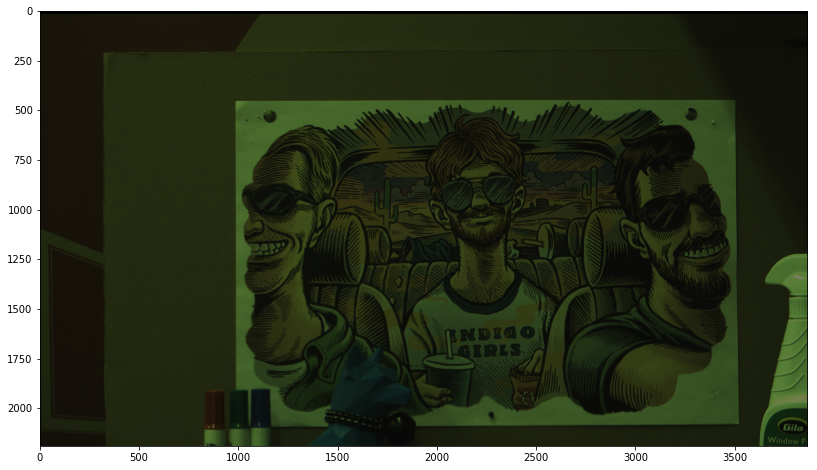

In [44]:
demo = demosaic(rIm)
plt.imshow(demo)

As it can be observed, this image is green heavy. We predicted this earlier by observing how the green channels were more highly valued in the raw bayer data. This can be corrected with the color adjust function written earlier.

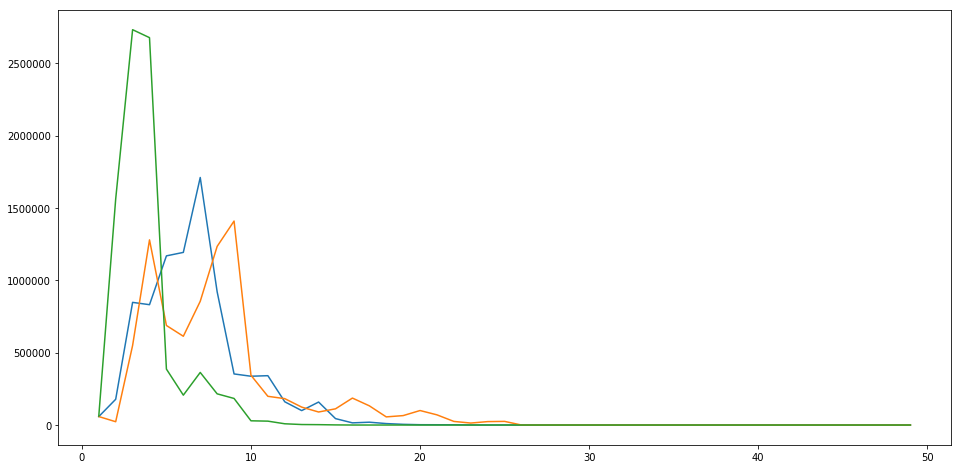

In [96]:
histr, bins = np.histogram(demo[:, :, 0], np.linspace(0, 1))
histg, bins = np.histogram(demo[:, :, 1], np.linspace(0, 1))
histb, bins = np.histogram(demo[:, :, 2], np.linspace(0, 1))
plt.plot(np.arange(1, 50), histr, np.arange(1, 50), histg, np.arange(1, 50), histb)

By observing the histogram we can make some predictions on how the color adjustment should go. For example, it is clear that most of the data is in the lower end of the histogram (for all channels), meaning we need some large gain to improve contrast. Additionally, we can make some rough estimations in that the blue channel needs to be amplified relative to the other two. 

After trying different combinations of parameters, these seemed to yield the best results:

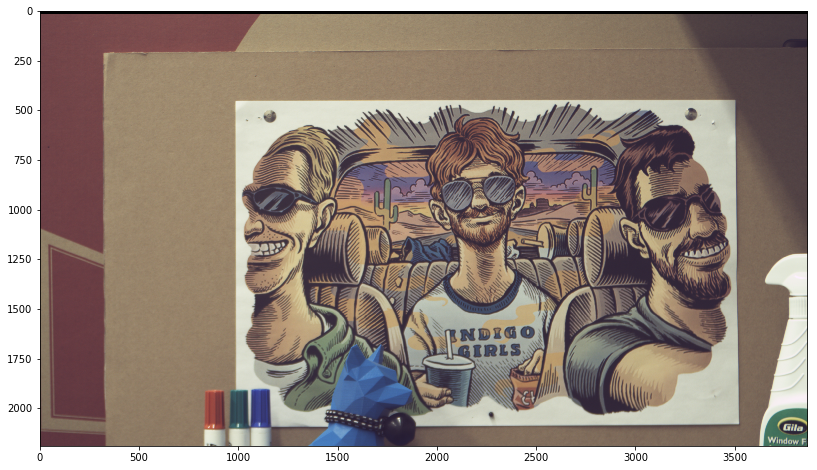

In [106]:
demo_adjust = adjustColor(demo, rc = 1, bc = 1.4, gc = 0.7, gain = 5)
plt.imshow(demo_adjust)

# Develop a neural network to train demosaicking in 

### Download the Kodak images

Go through the Kodak image set and add them to a list containing the 64x64 patches from all of them to use for later training.

In [198]:
pathname = 'Kodak24images'
train_set_ground_truth = []
for i in range(24):
    if i < 9:
        file_name = pathname + '/kodim0' + str(i + 1) + '.png'
    else:
        file_name = pathname + '/kodim' + str(i + 1) + '.png'
    a = imio.imread(file_name)
    for row in range(int(a.shape[0] / 64)):
        for col in range (int(a.shape[1] / 64)):
            patch = a[64*row : 64*row + 64, 64*col : 64*col + 64, :]
            train_set_ground_truth.append(patch)

For a proof of sanity, I make sure the R, G, and B channels correspond to the 0, 1, and 2 channels from the output of imio.imread. The image shown below shows how the first (0) channel brights up more in red. 
The images in the bottom row, it can be observed that the green trees light up more in the second (1) array of the image. this corresponds to the labels, so the RGB are stored as 0,1,2 correspondingly.

Text(0.5, 1.0, 'Full Color')

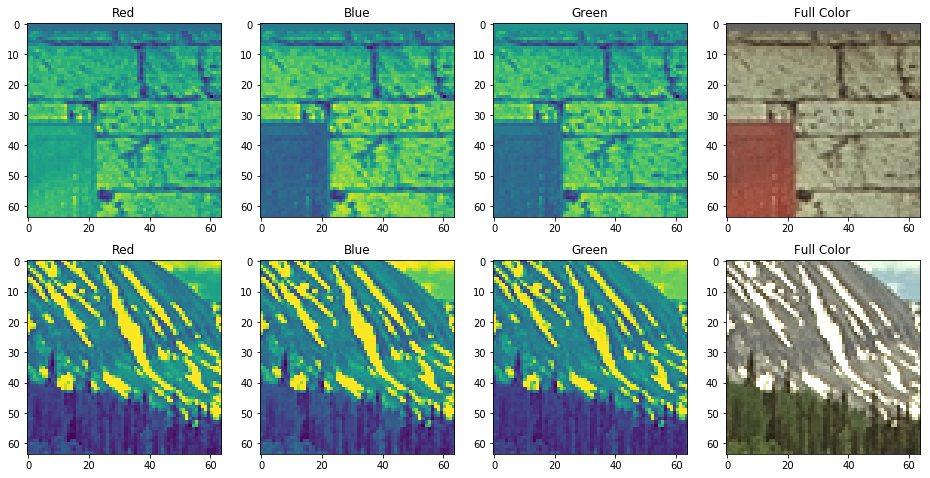

In [269]:
a = train_set_ground_truth[5]
plt.subplot(2,4,1)
plt.imshow(a[:, :, 0])
plt.title('Red')
plt.subplot(2,4,2)
plt.imshow(a[:, :, 1])
plt.title('Blue')
plt.subplot(2,4,3)
plt.imshow(a[:, :, 2])
plt.title('Green')
plt.subplot(2,4,4)
plt.imshow(a[:, :, :])
plt.title('Full Color')

a = train_set_ground_truth[1170]
plt.subplot(2,4,5)
plt.title('Red')
plt.imshow(a[:, :, 0])
plt.subplot(2,4,6)
plt.title('Blue')
plt.imshow(a[:, :, 1])
plt.subplot(2,4,7)
plt.title('Green')
plt.imshow(a[:, :, 2])
plt.subplot(2,4,8)
plt.imshow(a[:, :, :])
plt.title('Full Color')


Now we generate the virtual raw data from the training set by simulating the bayer process simply by downsampling each patches color channel by 4. I just find the raw bayer data by finding the corresponding pixel's value in the true image. I am aware that this ignores the intrinsic blurring that happens in the pixel function for a camera, so I believe downsampling with a kernel is better than picking static values. However, the image processing seemed just a little more complicated than necessary for that, and is not really the point of this HW.. So I demosaic by matching the pixel value for each point to the corresponding pixel in the appropriate channel information from the 'Ground Truth'.

In [270]:
def mosaic(RGB):
    raw_sim = np.zeros_like(RGB[:, :, 0])
    raw_sim[::2, ::2] = RGB[::2, ::2, 0]
    raw_sim[1::2, ::2] = RGB[1::2, ::2, 1]
    raw_sim[::2, 1::2] = RGB[::2, 1::2, 1]
    raw_sim[1::2, 1::2] = RGB[1::2, 1::2, 2]
        
    return  raw_sim

In [282]:
train_set_raw = []
for image in train_set_ground_truth:
    train_set_raw.append(mosaic(image))

For proof of sanity that this function is correctly mosaic:

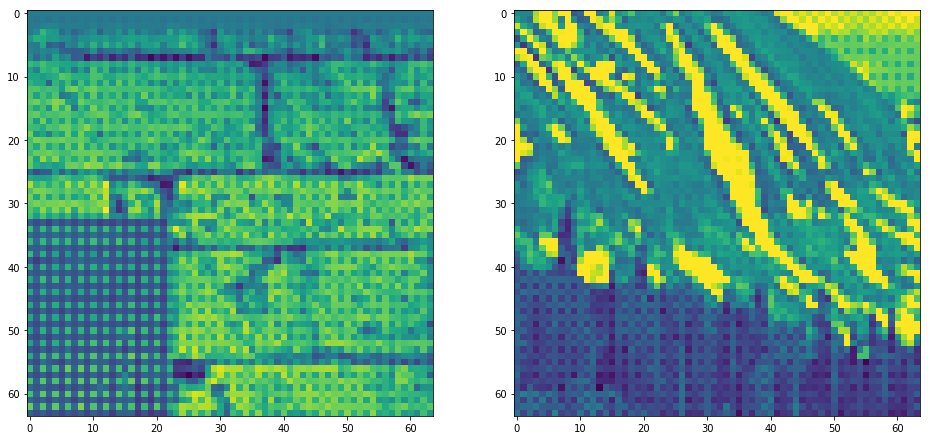

In [289]:
a, b = train_set_raw[5], train_set_raw[1170], 
plt.subplot(1,2,1)
plt.imshow(a)
plt.subplot(1,2,2)
plt.imshow(b)

Now that our training data is ready... We proceed to the fun part... The neural network!